# Optuna hyperparameter search analysis: UNet

In this notebook I analyse the results of a hyperparameter search run locally (completely outside of SageMaker) using the [Optuna](https://optuna.org/) open source package. This is a hyperparameter optimization framework that has options such as grid, random, and Bayesian based hyperparameter searches. In this case the hyperparameter tuning is for the UNet segmentation architecture.

This notebook includes:
- Brief discussion on how to run the hyperparameter search
- Analysis of the search results using Optuna
- Analysis of the search results using Weights and Biases

**Note:** This notebook is designed to be run on a local machine, not SageMaker.

## HPO optimization

### Runing Optuna HPO
The search is designed to be run on a local machine outside of SageMaker. As we saw in the previous notebook, performing HPO for this dataset on AWS SageMaker instances doesn't make sense from either a cost or a time perspective. Assuming you have a reasonable machine with GPU enabled traning then it is more practical to run this locally and then deploy the best model to SageMaker.

The script to run the search is called `optuna-hpo.py` and can be found in the `scripts` folder in the root of this Git repo. This will run a Tree-parzen estimator (TPE) hyperparameter search which uses Bayesian reasoning to select promising sets of hyperparameters based on previous results. Due to the number of outputs generated by the search, it's recommended to run it from a terminal. We then analyse the results in this notebook.

This script uses the `typer` package to facilitate passing arguments and options. You can view the help for the script by running:

`python optuna-hpo.py --help`

This should look something like shown below.

<p align="center">
  <img src="./../imgs/optuna-hpo-script-help.png" width=1200/>
</p>

Note that all of these have default values, so just running `python optuna-hpo.py` will start an Optuna study named `optuna-hpo` for a UNet model with 100 trials and a maximum of 50 epochs per trial.

The command run to generate the results in this notebook was:

`python optuna-hpo.py --study-name 'optuna-hpo-1' --model-type 'unet' --num-trials 100 --max-epochs 50 --num-workers 4 --no-fast-mode`

Note that I don't load all the data to GPU in this case as I was encountering some issues that I haven't been able to fix yet. Training was still much faster than on SageMaker.

### Hyperparameter search space
The search space for the hyperparameter tuning is defined inside the `objective` function inside the `optuna-hpo.py` script. The search space is currently defined for four hyperparameters as shown below:

```
num_filters_block_1 = trial.suggest_categorical("num_filters_block_1", [8, 16, 32])
dropout_rate = trial.suggest_uniform("dropout_rate", 0.0, 0.5)
batch_size = trial.suggest_categorical("batch_size", [16, 32])
learning_rate = trial.suggest_loguniform("learning_rate", 0.000001, 0.1)
```

Note that a log uniform sample is used for the learning rate due to the wide scale of the possible values.

## Import packages

In [8]:
import sys

import git
from IPython.display import IFrame
import matplotlib.pyplot as plt
import optuna
from optuna.visualization.matplotlib import (
    plot_contour, 
    plot_edf,
    plot_intermediate_values, 
    plot_slice,
    plot_optimization_history,
    plot_parallel_coordinate,
    plot_param_importances
)
import plotly

# Resolve repo root path and add to path
git_repo = git.Repo(".", search_parent_directories=True)
PROJECT_ROOT_PATH = git_repo.working_dir

sys.path.append(PROJECT_ROOT_PATH)

from sagemaker_src.brain_model import BrainMRIModel

In [ ]:
plotly.offline.init_notebook_mode() # So figures can bae seen when viewing notebooks from GitHub

## HPO analysis

### Load study results
First we need to load the results output by the study in an SQLite database. You will need to first run a search (using the instructions above) if you want to re-run this part of the notebook. If you used a different study name then change it below.

In [27]:
study_name = 'optuna-hpo-1'
storage = f"sqlite:///{PROJECT_ROOT_PATH}/optuna/{study_name}.db"

In [28]:
study = optuna.load_study(study_name=study_name, storage=storage)
df = study.trials_dataframe(attrs=("number", "value", "params", "state"))

Now we have the results in the form of a Pandas DataFrame:

In [29]:
df

,number,value,params_batch_size,params_dropout_rate,params_learning_rate,params_num_filters_block_1,state
0,0,0.709740,32,0.310313,0.000016,16,COMPLETE
1,1,0.804716,32,0.204895,0.012002,32,COMPLETE
2,2,0.610038,32,0.365767,0.000001,16,COMPLETE
3,3,0.739032,32,0.013307,0.000007,32,COMPLETE
4,4,0.733355,16,0.470779,0.000026,32,COMPLETE
...,...,...,...,...,...,...,...
95,95,0.825577,16,0.060582,0.000951,32,COMPLETE
96,96,0.772629,16,0.009005,0.000551,32,PRUNED
97,97,0.759230,16,0.022077,0.003214,32,PRUNED
98,98,0.819856,16,0.037090,0.001227,32,COMPLETE


### Best trial
We can extract the information for the best trial (i.e. highest validation Dice score) as follows:

In [30]:
print(f'Best trial until now: {study.best_trial.number}')
print(f'Best validation score: {study.best_trial.values[0]}')
print(f'Best trial parameters:')
for key, value in study.best_trial.params.items():
    print(f'        {key}: {value}')

Best trial until now: 84
Best validation score: 0.8394409418106079
Best trial parameters:
        batch_size: 16
        dropout_rate: 0.01974680258630745
        learning_rate: 0.0010872470329461143
        num_filters_block_1: 32


So trial 84 produced the best model with a mean Dice score of 0.839.

### Optimization history

Optuna also provide some nice plotting functions to visualize the results. Below is a plot of the optimization history, with the red line indicating the progress of the best validation Dice score (where higher is better).

plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.


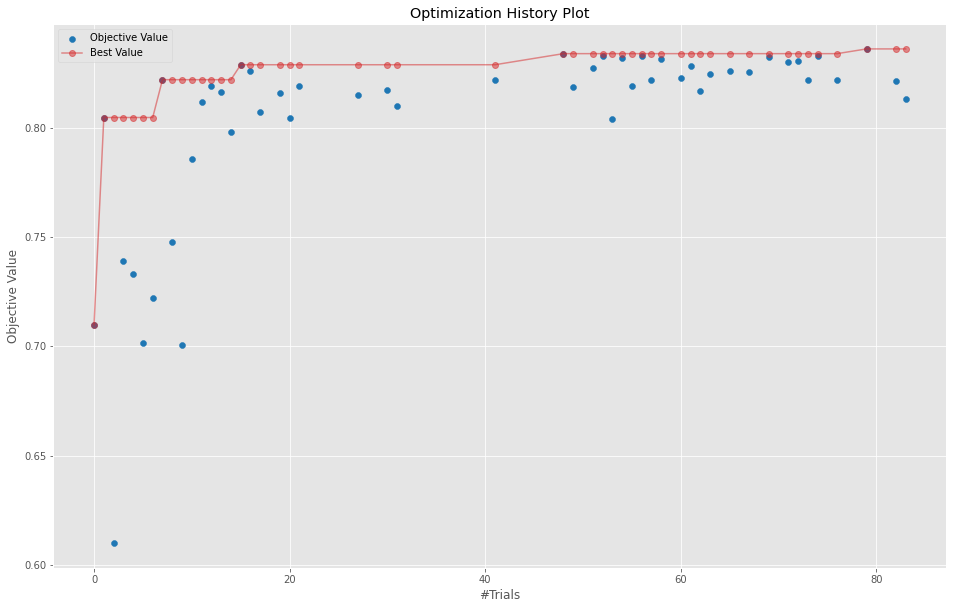

In [20]:
plot_optimization_history(study)
fig = plt.gcf()
fig.set_size_inches(16,10)

### Slice plot

We can also make a slice plot, which plots the metric score against the different hyperparameters used in the search.

plot_slice is experimental (supported from v2.2.0). The interface can change in the future.


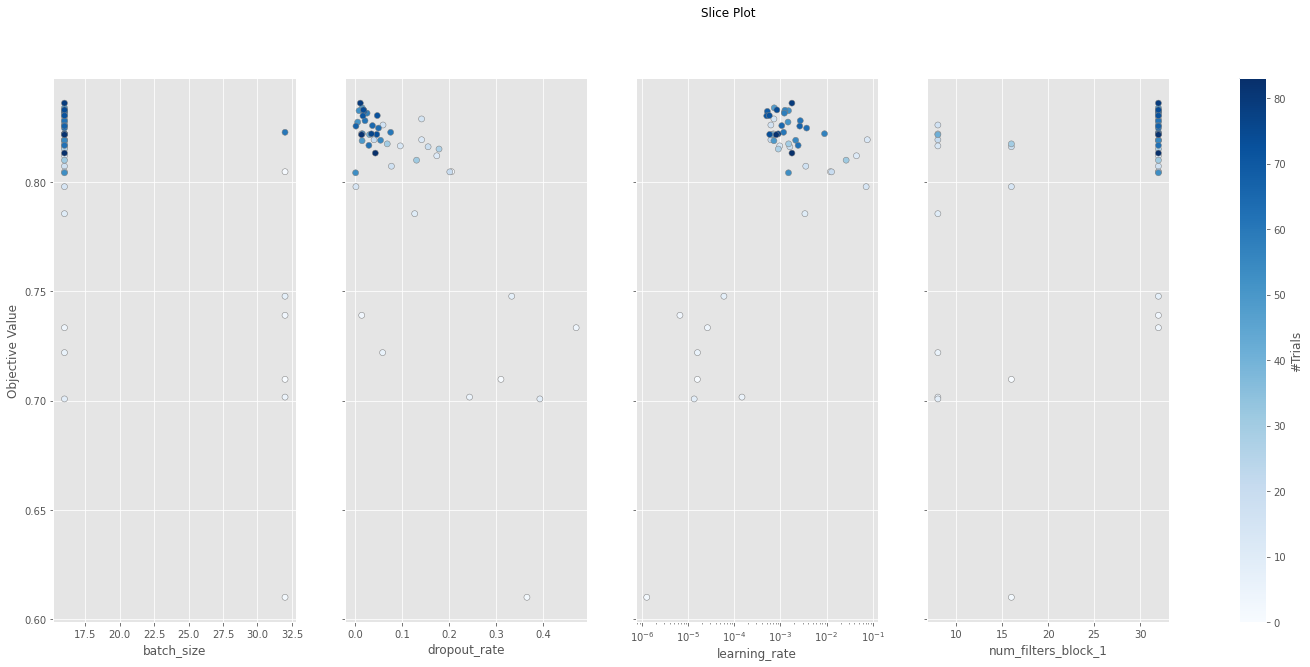

In [27]:
plot_slice(study)
fig = plt.gcf()
fig.set_size_inches(25,10)

So we can see that the search seems to converge to a learning rate around 0.001 and a small dropout rate less than 5%.

### Hyperparameter importance

There is also a tool which will plot the importanaces of the different hyperparameters. This indicates that the learning rate and the number of filters in the first block are the most important, although I'm not exactly sure how this is calculated.

plot_param_importances is experimental (supported from v2.2.0). The interface can change in the future.


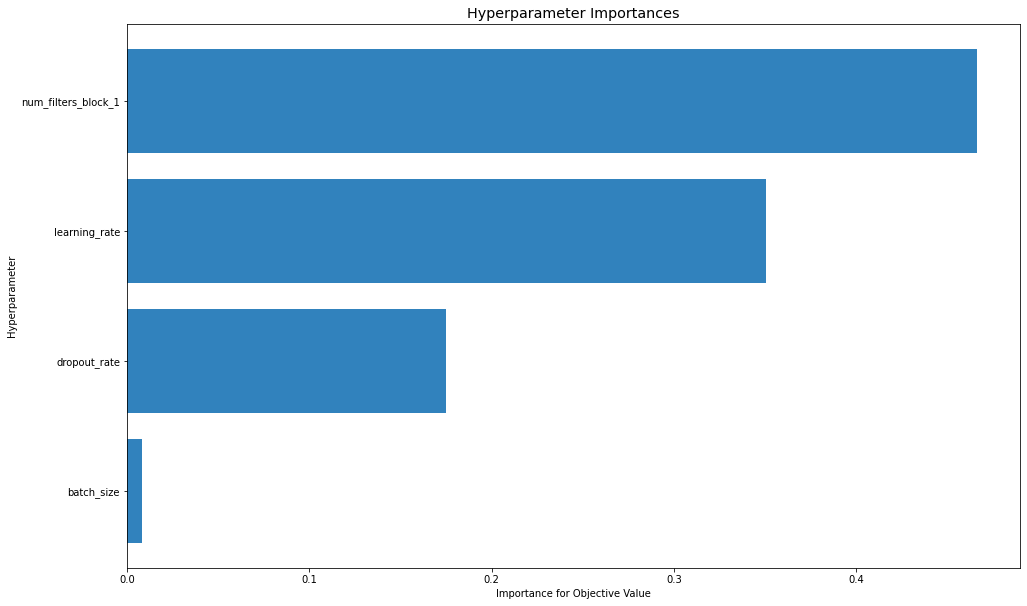

In [31]:
plot_param_importances(study)
fig = plt.gcf()
fig.set_size_inches(16,10)

### Weights and Biases

The experiments were also tracked using Weights and Biases. You can visit the project here (note this includes other experiments aside from this hyperparameter search): https://wandb.ai/robsmith155/brain-mri-segmentation

The outputs from trial 84 (the best model) are shown by running the cell below. This includes example predictions on validation slices as the model is being trained, system information, hyperparameters and metrics.

**Note:** When I ran this search I didn't realise that by default Weights and Biases will use the final epoch as the value to report in the metric summary. Therefore, looking at the table of results won't show trial 84 as being the best. To change this behaviour, the following needed to be added in the PyTorch Lightning module:

```
def validation_step(self, batch, batch_idx):
    if self.current_epoch == 0:
        wandb.define_metric("val_mean_dice", summary="max")
    val_batch_size = len(batch)...

```

%%html
<iframe src="https://wandb.ai/robsmith155/brain-mri-segmentation/runs/mwk66y5o?workspace=user-robsmith155" width="1200" height="1000"></iframe>